# Advanced lane lines finding

**In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.** 

## Step1: Camera Calibration with OpenCV

### Run the code in the cell below to extract object points and image points for camera calibration.  

Geometric camera calibration, also referred to as camera resectioning, estimates the parameters of a lens and image sensor of an image or video camera. You can use these parameters to correct for lens distortion, measure the size of an object in world units, or determine the location of the camera in the scene.

In [27]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
%matplotlib qt



In [2]:

# Read in a calibration image and display
img = mpimg.imread('camera_cal/calibration1.jpg')
print ("Calibration image shape is: ",img.shape)


Calibration image shape is:  (720, 1280, 3)


In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # mgrid() generates x and y coordinates

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Using subplot to display a grid of 20-images
fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #print (ret)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #plt.imshow( img)
        #cv2.waitKey(500)
        axs[idx].axis('off')
        axs[idx].imshow(img)

#cv2.destroyAllWindows()

### Here, I will do camera calibration (Note: this step should be done only once)

In [5]:
import pickle
%matplotlib inline

# Test undistortion on an image used for calibrtion
img = mpimg.imread('camera_cal/calibration1.jpg')
print(img.shape)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points, this step should be done once
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print(" Camera Calibration done")

(720, 1280, 3)
 Camera Calibration done


Text(0.5,1,'Undistorted Image')

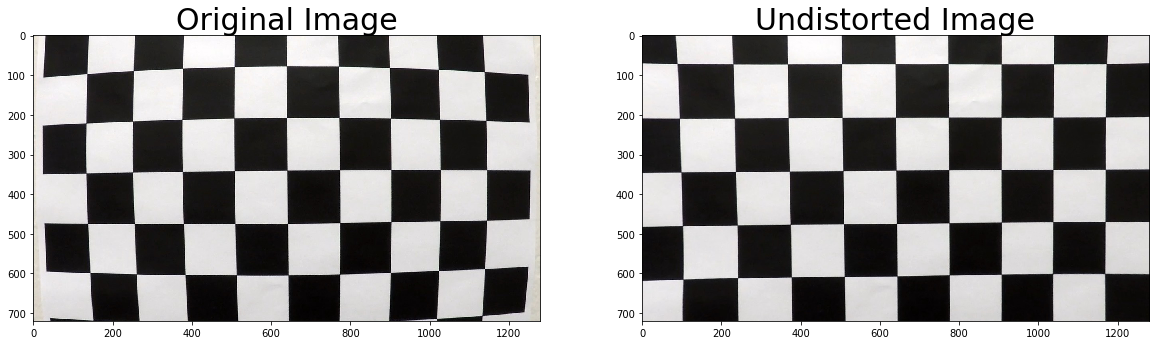

In [6]:
# testing the effect of undistortion on a test image

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibtation1_dst.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/cal_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### In the next steps, up to step 8, I will apply every step and see the output on a test image, then after i will build my pipeline function and apply on all supported test images and then on the video.

## Step 2: Undistort and warp the image (Perspective transform)

**Here I will apply distortion correction and warp the image to get bird's view of the image**

In [2]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients (returned values from camera calibration step)
def corners_unwarp(img, img_size, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
   
    # define source and destination points for transform, which are chosen manually
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 450 pixels is not exact, but close enough for our purpose here
    offset = 450 # offset for dst points
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
    dst = np.float32([(offset,0),
                  (img.shape[1]-offset,0),
                  (offset,img.shape[0]),
                  (img.shape[1]-offset,img.shape[0])])
        
        
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Calculate the reversed perspective transform matrix to use in returing back from warped image to original image
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        
    # Return the resulting undistorted and warped image and matrix
    return warped, M, Minv

print('end')


end


(720, 1280, 3)


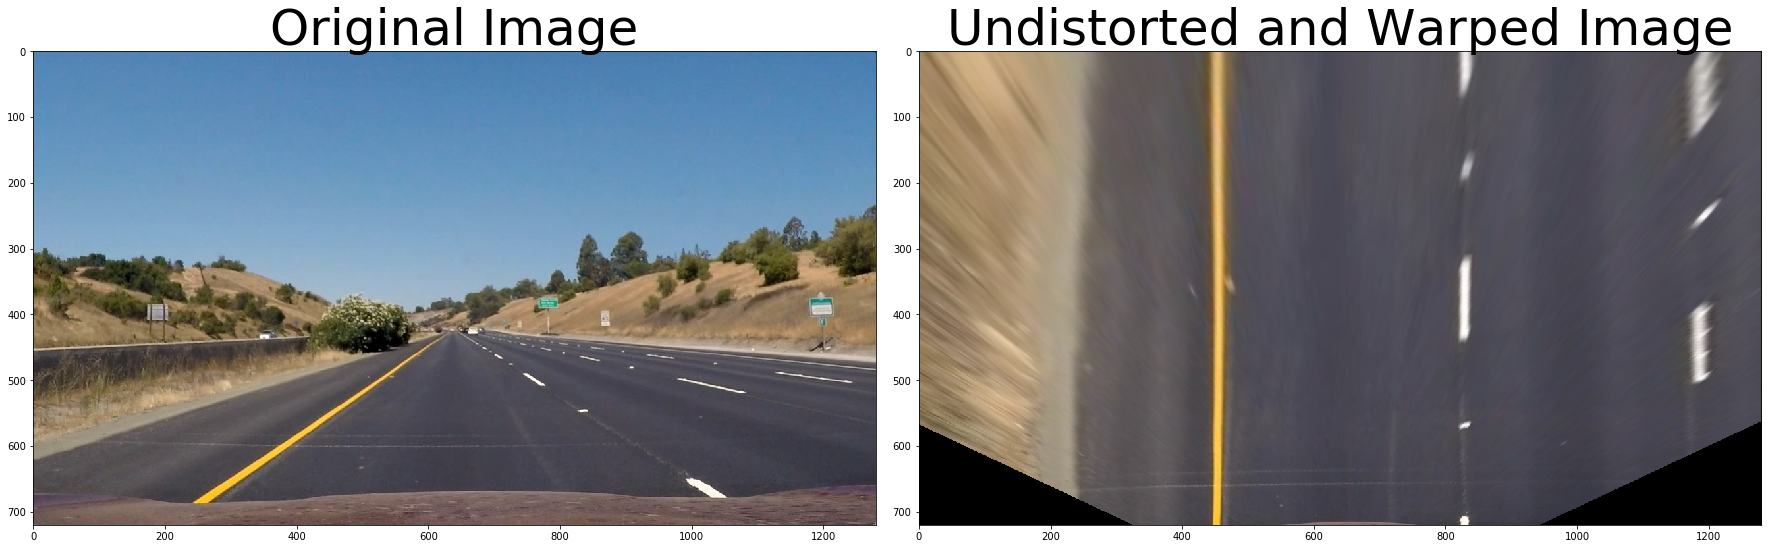

In [8]:
# Testing the corners_unwarp() function on a test image

img = mpimg.imread('test_images/straight_lines1.jpg')
print(img.shape)
img_size = (img.shape[1], img.shape[0])

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

top_down, perspective_M, Minv = corners_unwarp(img, img_size, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##  Step2: Apply combind thresholds to our un-distorted and warped image, and get a combined binary image as shown below.
 
 **Gradient threshold + Gradient magnitude threshold + Gradient direction threshold**

In [3]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    
    return sbinary
    
    
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output



# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

    
    


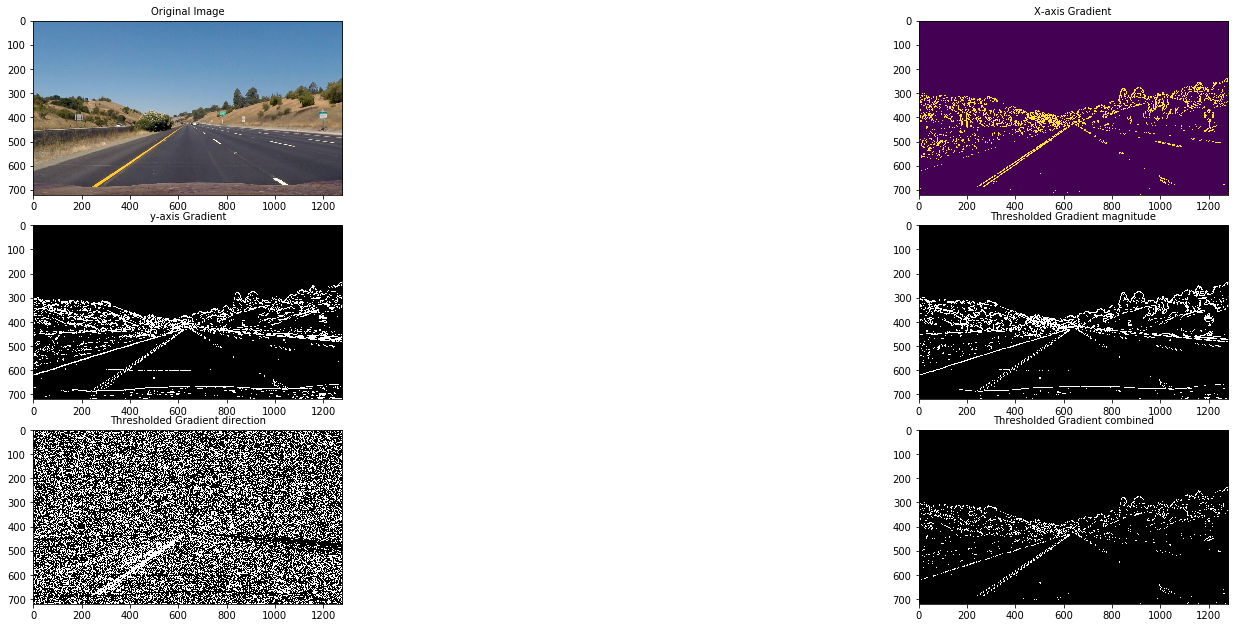

In [10]:
# Testing the 3-threshold functions on a test image

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, dir_thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, axs = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title('Original Image', fontsize=10)
axs[1].imshow(gradx)
axs[1].set_title('X-axis Gradient', fontsize=10)
axs[2].imshow(grady, cmap='gray')
axs[2].set_title('y-axis Gradient', fontsize=10)
axs[3].imshow(mag_binary, cmap='gray')
axs[3].set_title('Thresholded Gradient magnitude', fontsize=10)
axs[4].imshow(dir_binary, cmap='gray')
axs[4].set_title('Thresholded Gradient direction', fontsize=10)
axs[5].imshow(combined, cmap='gray')
axs[5].set_title('Thresholded Gradient combined', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

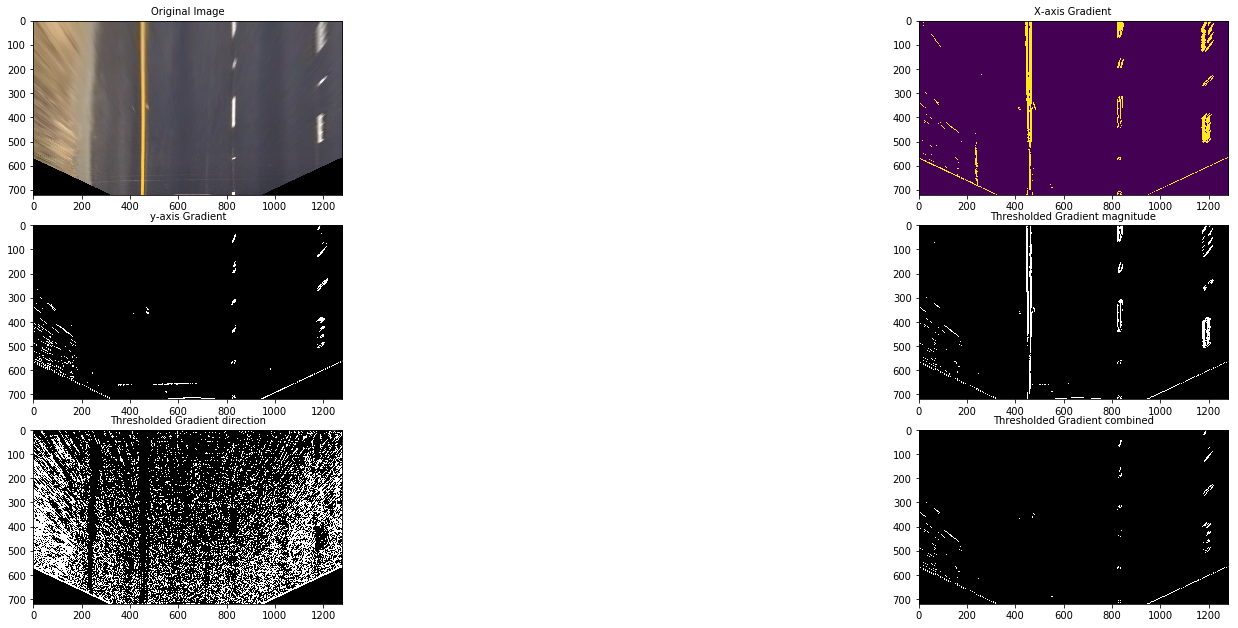

In [11]:

# Testing the 3-threshold functions on a warped  image

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(top_down, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(top_down, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(top_down, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(top_down, sobel_kernel=ksize, dir_thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, axs = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
axs = axs.ravel()
axs[0].imshow(top_down)
axs[0].set_title('Original Image', fontsize=10)
axs[1].imshow(gradx, cmap='gray')
axs[1].set_title('X-axis Gradient', fontsize=10)
axs[2].imshow(grady, cmap='gray')
axs[2].set_title('y-axis Gradient', fontsize=10)
axs[3].imshow(mag_binary, cmap='gray')
axs[3].set_title('Thresholded Gradient magnitude', fontsize=10)
axs[4].imshow(dir_binary, cmap='gray')
axs[4].set_title('Thresholded Gradient direction', fontsize=10)
axs[5].imshow(combined, cmap='gray')
axs[5].set_title('Thresholded Gradient combined', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

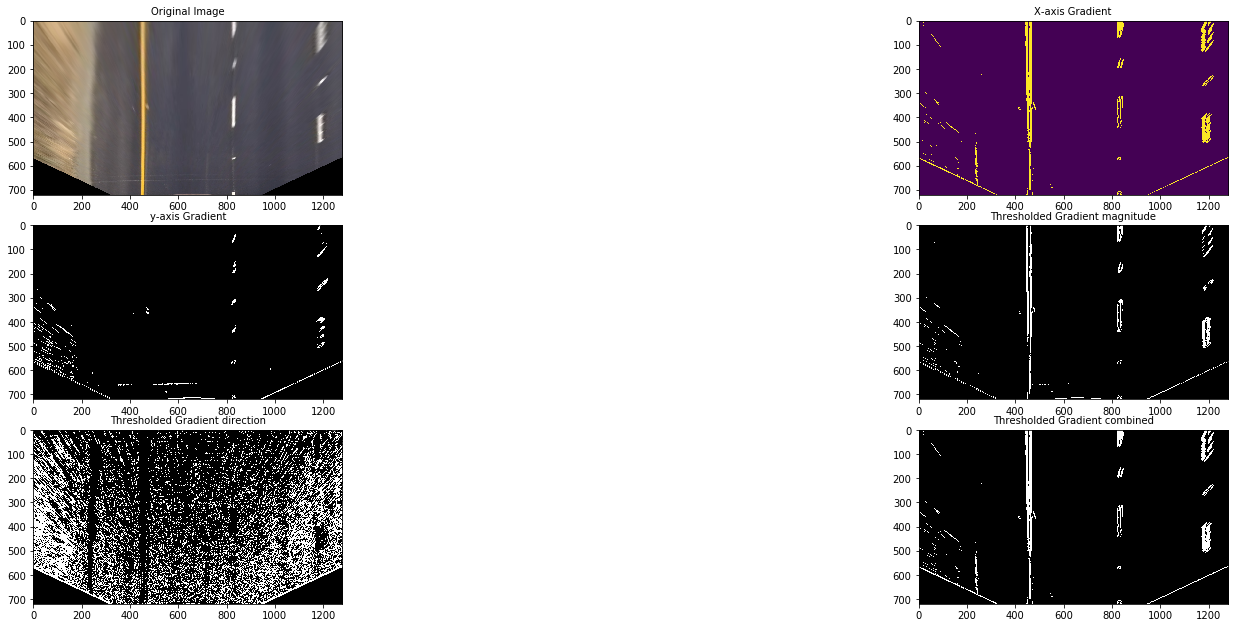

In [12]:

# Testing the 3-threshold functions on a warped  image, without y-axis gradient

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(top_down, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(top_down, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(top_down, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(top_down, sobel_kernel=ksize, dir_thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1 # removing grady for better result

# Plot the result
f, axs = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
axs = axs.ravel()
axs[0].imshow(top_down)
axs[0].set_title('Original Image', fontsize=10)
axs[1].imshow(gradx)
axs[1].set_title('X-axis Gradient', fontsize=10)
axs[2].imshow(grady, cmap='gray')
axs[2].set_title('y-axis Gradient', fontsize=10)
axs[3].imshow(mag_binary, cmap='gray')
axs[3].set_title('Thresholded Gradient magnitude', fontsize=10)
axs[4].imshow(dir_binary, cmap='gray')
axs[4].set_title('Thresholded Gradient direction', fontsize=10)
axs[5].imshow(combined, cmap='gray')
axs[5].set_title('Thresholded Gradient combined', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##  Step 3: Color and Gradient threshold

**In this step, I will apply combined Gradient threshold on a filtered image version of the original image, here as suggested, I will use and s-channel filtered image and then will test on both normal image and undist+warped image as in Step2, testing part.**

In [4]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
def s_threshold(img, s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary


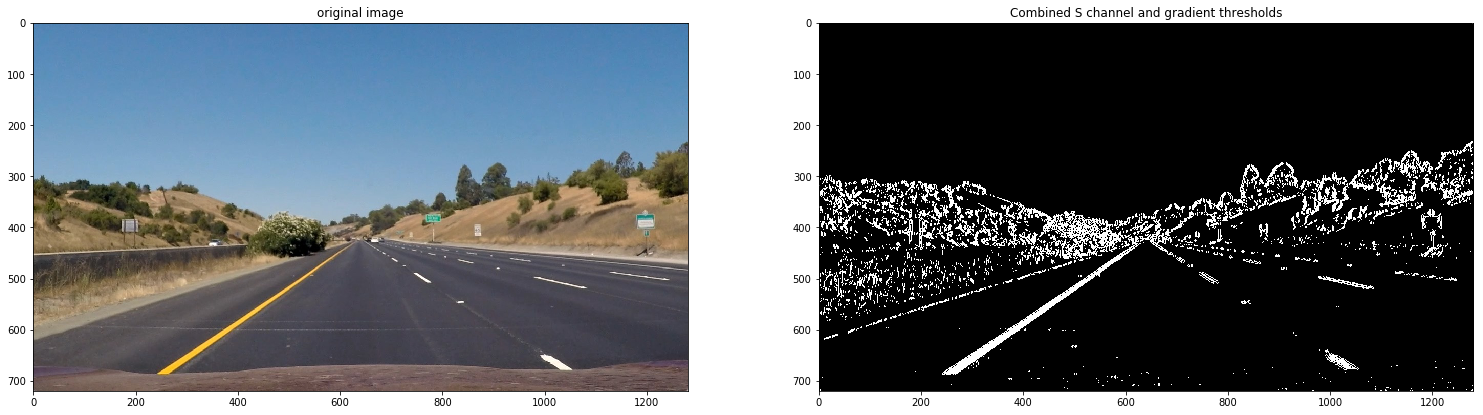

In [14]:
# Testing both combined s-channel and Gradient thresholds on image

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, dir_thresh=(0.7, 1.3))
s_binary = s_threshold(img, s_thresh=(170, 255))

combined = np.zeros_like(dir_binary)
combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined)
combined_binary[(s_binary == 1) | (combined == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original image')
ax1.imshow(img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

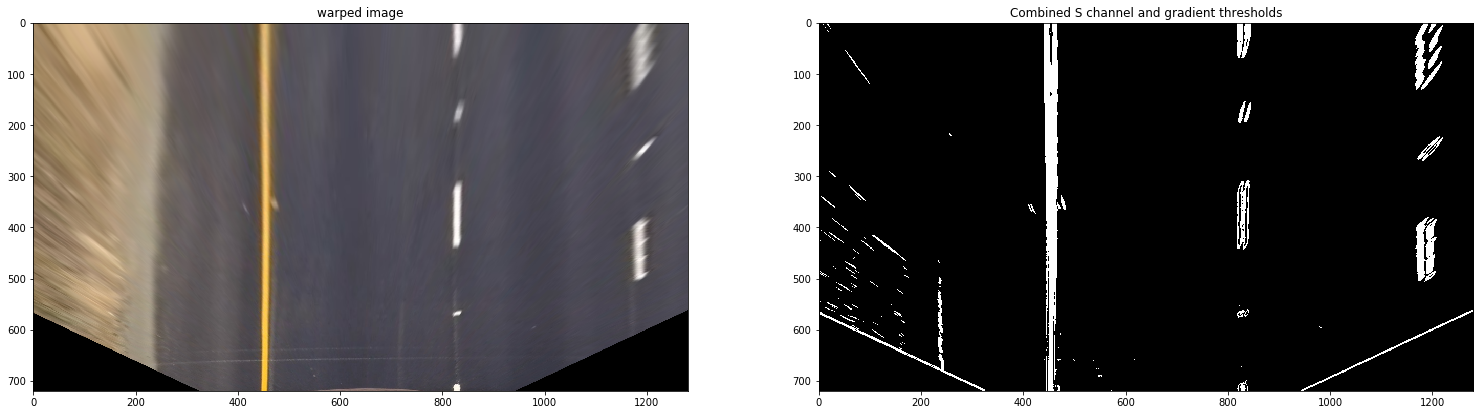

In [15]:
# Testing both combined s-channel and Gradient thresholds on an undistorted and warped

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(top_down, orient='x', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(top_down, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(top_down, sobel_kernel=ksize, dir_thresh=(0.7, 1.3))
s_binary = s_threshold(top_down, s_thresh=(170, 255))

combined = np.zeros_like(dir_binary)
combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined)
combined_binary[(s_binary == 1) | (combined == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('warped image')
ax1.imshow(top_down)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 4: In this step I will build my pipeline

**Here I will merge all previous steps in one pipeling fuction and apply on all test images**

In [11]:
def pipeline(img, ksize, thresh1, mag_thresh1, dir_thresh1, s_thresh1):
    '''
    this function returns a binary image version of the passed image after applying all pipeline steps(undistort+warp+combined gradient thresholds+s_channel threshold)
    this function should be called as a stage1 of the project, before finding lane lines
    to get better output, call this function using this line: output = pipeline(img, ksize=7, thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3), s_thresh=(170, 255))
    '''
   

    #img_size = (img.shape[1], img.shape[0])
    img_size = (1280, 720)
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load( open( "camera_cal/cal_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # Remove distortion and apply perspective transform to get bird's eye view of the input image
    top_down, perspective_M, Minv = corners_unwarp(img, img_size, mtx, dist)
    # Apply each of the thresholding functions
    #gradx = abs_sobel_thresh(top_down, orient='x', sobel_kernel=ksize, thresh=thresh1)
    #mag_binary = mag_thresh(top_down, sobel_kernel=ksize, mag_thresh=mag_thresh1)
    #dir_binary = dir_threshold(top_down, sobel_kernel=ksize, dir_thresh=dir_thresh1)
    #s_binary = s_threshold(top_down, s_thresh=s_thresh1)
    #r_binary = r_threshold(top_down) #using default threshold
    l_binary = l_threshold(top_down) #using default threshold
    b_binary = b_threshold(top_down) #using default threshold
    # Combine all Gradient binary thresholds
    #combined = np.zeros_like(dir_binary)
    #combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1

    #combined_binary = np.zeros_like(combined)
    #combined_binary[(s_binary == 1) | (combined == 1)] = 1
     
     # Combine R-channel and L-channel thresholds
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1)  |(b_binary == 1)] = 1   
    return combined_binary, Minv   

print('end')

end


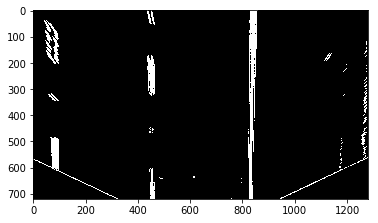

In [40]:
# testing pipe line on another image from test_images

img = mpimg.imread('test_images/straight_lines2.jpg')
img2, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))
plt.imshow(img2, cmap='gray')

In [18]:
# Test Pipeline on the rest of the test_images
import os

# List the Images, here test_images has 8-Images
os.listdir("test_images")



['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [19]:
# Make a list of images names in test_images folder
images1 = sorted(glob.glob('./test_images/*.png'))
images2 = sorted(glob.glob('./test_images/*.jpg'))
images = np.concatenate((images1, images2), axis=0)

test_images = [] # make a list to save in all read images.
outputs = [] # make a list of all images after applying pipeline

# Read images 
#for image in images:
    #img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    #img = mpimg.imread(image)
    #print(img.shape)
   # print( "Img"+str(i+1)+" = ",img.shape)
  #test_images.append(img)
    
img = mpimg.imread('test_images/straight_lines1.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)

img = mpimg.imread('test_images/straight_lines2.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)

img = mpimg.imread('test_images/test1.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)

img = mpimg.imread('test_images/test2.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)

img = mpimg.imread('test_images/test3.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)

img = mpimg.imread('test_images/test4.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)

img = mpimg.imread('test_images/test5.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)

img = mpimg.imread('test_images/test6.jpg')
output, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
test_images.append(img)
outputs.append(output)
#print (len(test_images))  # expecting len= 8
# Apply the pipeline on each image in test_images[]
#for img in images:
 #   output = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))
  #  outputs.append(output)
print ("lenght of outputs : ", len(outputs))  # expecting len= 8

    

lenght of outputs :  8


length of images to display =  16


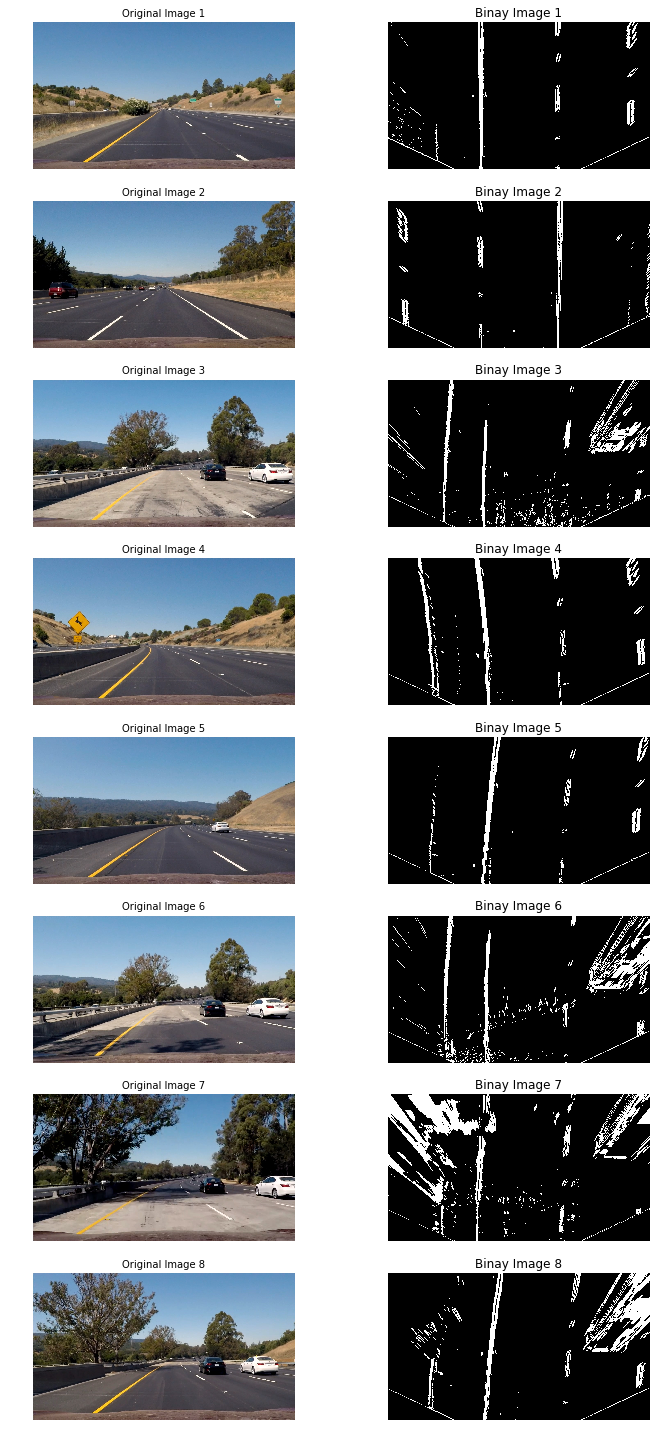

In [20]:
display = []

for i in range(8):
    display.append(test_images[i])
    display.append(outputs[i])
    
print("length of images to display = ", len(display))

# Using subplot to display a grid of 20-images
f, axs = plt.subplots(8, 2, figsize=(10, 20))
f.tight_layout()
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(16):
    axs[i].axis('off')
    if(i%2 == 0):
        axs[i].imshow(display[i])
        axs[i].set_title("Original Image {}".format((i//2)+1), fontsize=10)
    else:
        axs[i].imshow(display[i],  cmap='gray')
        axs[i].set_title("Binay Image {}".format((i//2)+1))
     

As shown above, images with lots of shadows effect, hold alot of noise in the binary version, as in images 6 & 7.

So, I will add to the pipeline, another color threshold. Since, R-channel still does good job on white lines, perhaps  better than S-channel. So  will combine it with the Binary image from the pipeline and test.

### Adding R-Channel threshold.

In [5]:
#  Separate the R- channel
# Note: img is the undistorted image
def r_threshold(img, r_thresh=(200, 255)):
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    return r_binary


Text(0.5,1,'Pipeline Image with R_channel')

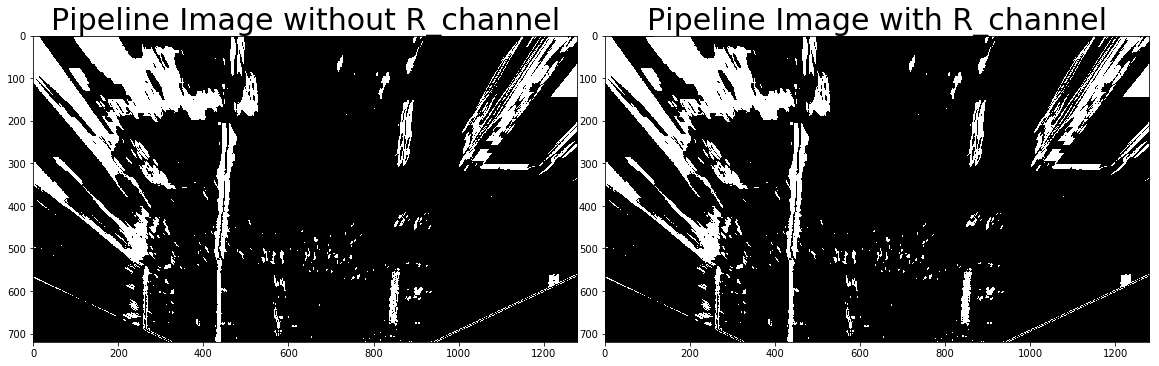

In [32]:
# testing on image 7
bin_image, Minv = pipeline(test_images[6], ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
undist , perspective_M, Minv = corners_unwarp(test_images[6], img_size, mtx, dist)
r_binary = r_threshold(undist) # using default threshold

# Combine the two binary thresholds
combined_binary = np.zeros_like(bin_image)
combined_binary[(r_binary == 1) | (bin_image == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(bin_image, cmap= 'gray')
ax1.set_title('Pipeline Image without R_channel', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Image with R_channel', fontsize=30)


As shown above, the image doesn't show big difference even with changing in the threshold values!, so I will now try the L-Channel threshold and see the effect.

In [6]:
# Convert to HLS color space and separate the L channel
# Note: img is the undistorted image
def l_threshold(img, l_thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return l_binary

Text(0.5,1,'Pipeline Image with L_channel')

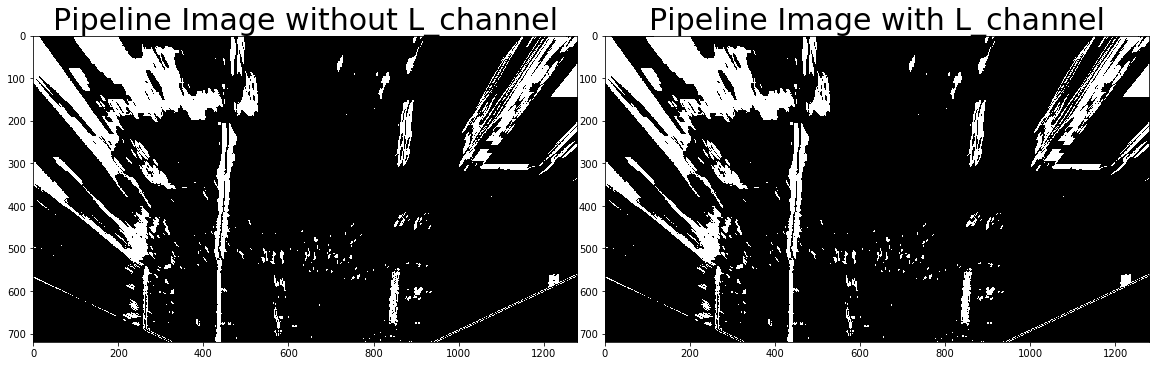

In [34]:
# testing on image 7

l_binary = l_threshold(undist) # using default threshold

# Combine the two binary thresholds
combined_binary = np.zeros_like(bin_image)
combined_binary[(l_binary == 1) | (bin_image == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(bin_image, cmap= 'gray')
ax1.set_title('Pipeline Image without L_channel', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Image with L_channel', fontsize=30)


Now I will test the pipeline on all images (new pipeline only uses combined R and L trhesholds )

In [7]:

def test_plt():
    '''
    This function is used to read the test_images and plot them before and afte applying the pipeline
    '''
    # get list of test images
    images = glob.glob('./test_images/*.jpg')
    # Set up plot
    fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()           
    i = 0
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
        axs[i].imshow(img)
        axs[i].axis('off')
        i += 1
        axs[i].imshow(bin_img, cmap='gray')
        axs[i].axis('off')
        i += 1


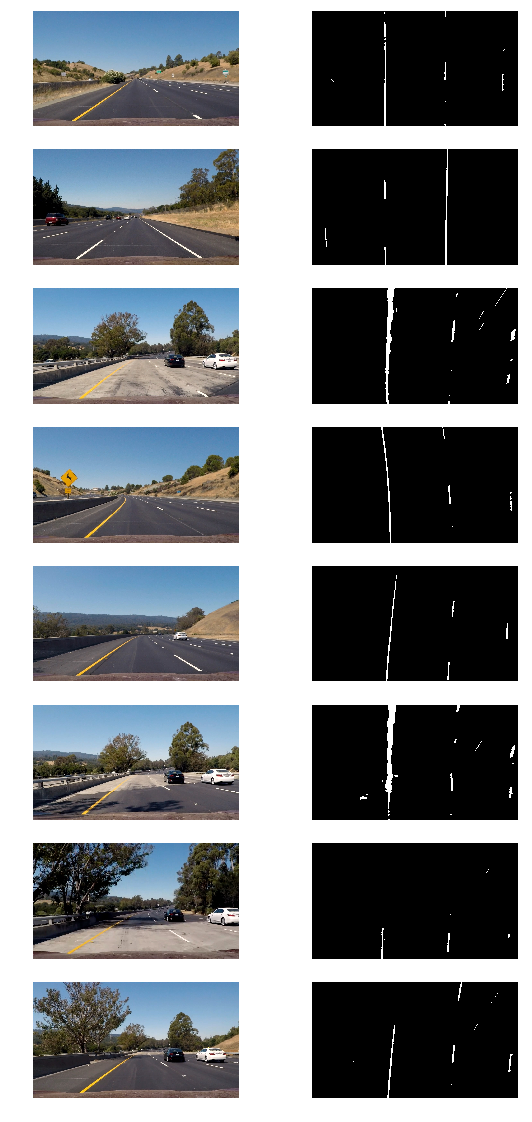

In [49]:
test_plt()

As shown above, the shadows and lightness effect is getting better after combining both R-channel and L-channel threshold more than it was when using S-channel. No as shown in the last 2-images (image 6,7), we still have problem with yellow lines. as suggested [here](https://communities.theiet.org/discussions/viewtopic/348/19442), to best grab the yellow color is shifting to LAB color space and filt B-channel, so I will add the b-channel() function to the pipeline and test. since B-channel shows how yellow or blue the colour is.

In [13]:
# Convert to LAB color space and separate the B-channel
# Note: img is the undistorted image
def b_threshold(img, b_thresh=(170, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    return b_binary

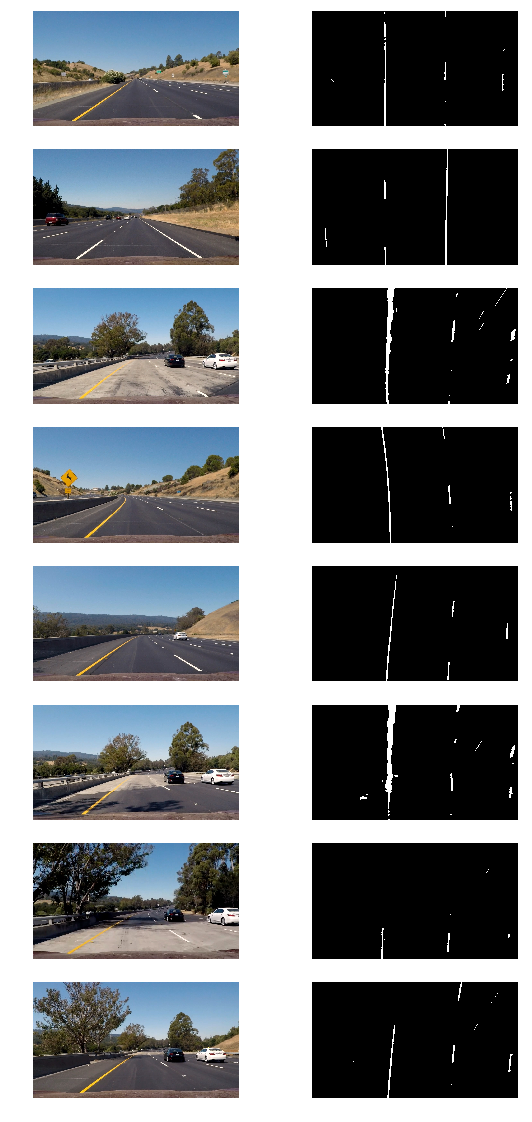

In [54]:
test_plt()

As shown above, I can't see a big enhancement in combining R-L-B channels more than just using R-L channels,so now I will do some expirement to get the best combination of channels

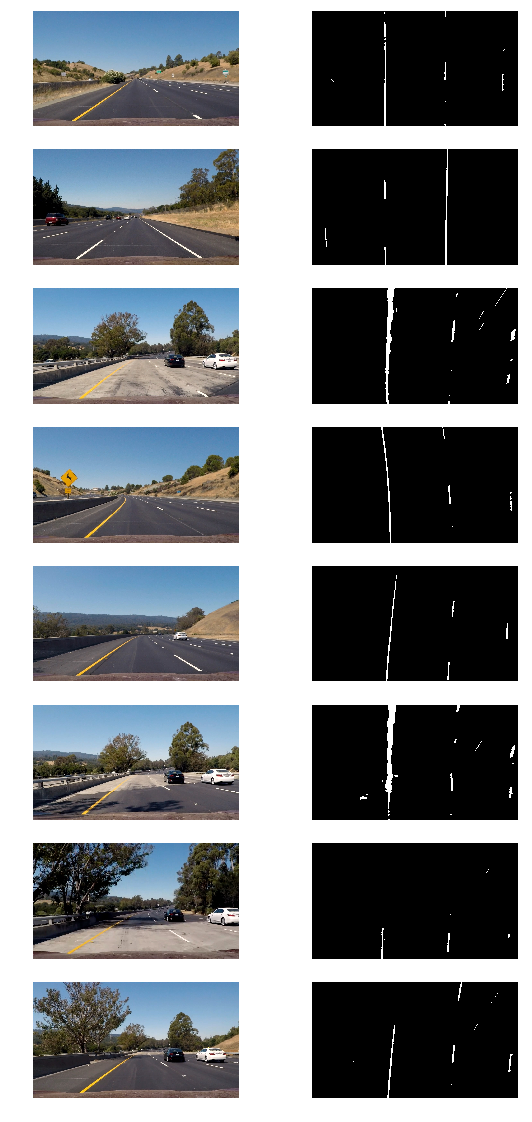

In [72]:
test_plt() # best result I got so far is just combining R-L-B channels

# Step 5: Finding the lane lines and fit polynomial

### Line Finding Method: Peaks in a Histogram

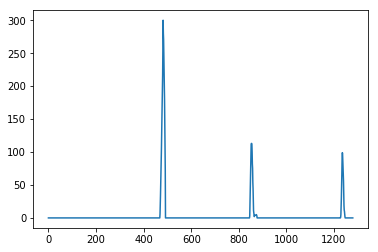

In [160]:
# test on a random from test_images binary image after applying the pipeline
img = mpimg.imread('test_images/test2.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  

histogram = np.sum(bin_img[bin_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)


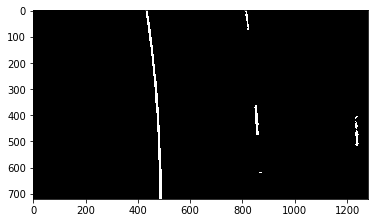

In [86]:
plt.imshow(bin_img, cmap='gray') # plot the binary image whose histogram is plotted above

### Implement Sliding Windows and Fit a Polynomial

Since I found that ther are some misleading information on the right of the image, I decided to crop a small part of the right of the image, as shown in the following funciton

In [14]:

# test on a random from test_images binary image after applying the pipeline and cropping
img = mpimg.imread('test_images/test2.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
img = bin_img[0:720, 0:1100] #slicing arrays, giving the [startY:endY,startX:endX] coordinates to the slice.
#res = cv2.resize(cropped,(1280, 720), interpolation = cv2.INTER_CUBIC)
print(img.shape)
plt.imshow(img, cmap='gray') # plot the binary image whose histogram is plotted above

(720, 1100)


In [15]:
def lane_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    
    binary_warped = binary_warped[0:720, 0:1100] # crop some unwanted information from the right side
    #binary_warped = cv2.resize(cropped,(1280, 720), interpolation = cv2.INTER_CUBIC) # resize the cropped image to the original size
    
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) 
    #Note: I used the bottom 1/3 of the image to get the histogram, it was more accurate for me
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0) 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10 # this value is adjusted
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80 # this value is adjusted
    # Set minimum number of pixels found to recenter window
    minpix = 40 # this value is adjusted
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
   # ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
   # right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

   # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
   # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   # plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
   # plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
   # plt.ylim(720, 0)
    return left_fit, right_fit
    
print('end')    

end


In [16]:
# test drawing lane lines  on test2.jpg
img = mpimg.imread('test_images/test2.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  

left_fit, right_fit = lane_lines(bin_img)

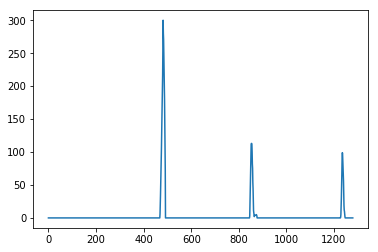

In [93]:
histogram = np.sum(bin_img[bin_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

As shown above, for the image I am testing here, which is (test2.jpg), as the histogram peaks correctly reflects the lane lines, so the function lane_lines(), correctly draws them, however in (test1.jpg), since historgram shows peaks on the right side of the road not the lane lines, the functiion lane_lines() didn't work correctly as shown bellow.

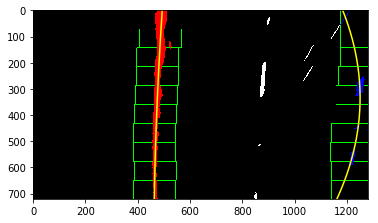

In [114]:
# test drawing lane lines  on test1.jpg
img = mpimg.imread('test_images/test1.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  

left_fit, right_fit = lane_lines(bin_img)

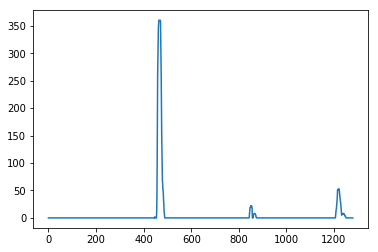

In [116]:
histogram = np.sum(bin_img[bin_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [ ]:
histogram = np.sum(bin_img[bin_img.shape[0]//3:,:], axis=0)
plt.plot(histogram)

### Skip the sliding windows step once you know where the lines are

In [17]:
def lane_lines_fit(binary_warped, left_fit, right_fit):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy
    
print('end')   

end


In [18]:
def visualize_lane_lines_fit(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    margin = 80
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                 ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return result, left_fitx, right_fitx, ploty
    
print('end')    
    

end


(720, 0)

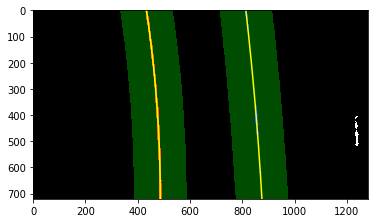

In [151]:
# test drawing lane lines fit  on test2.jpg
img = mpimg.imread('test_images/test2.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  

left_fit, right_fit = lane_lines(bin_img)
left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = lane_lines_fit(bin_img, left_fit, right_fit)
result, left_fitx, right_fitx, ploty = visualize_lane_lines_fit(bin_img,left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

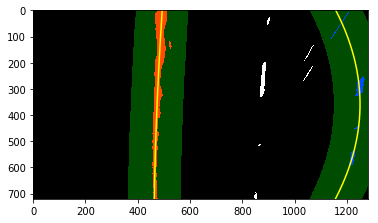

In [143]:
# test drawing lane lines fit  on test1.jpg
img = mpimg.imread('test_images/test1.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  

left_fit, right_fit = lane_lines(bin_img)
left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = lane_lines_fit(bin_img, left_fit, right_fit)
result, left_fitx, right_fitx, ploty = visualize_lane_lines_fit(bin_img,left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [19]:
def lane_lines_test_plt():
    '''
    This function is used to read the test_images and plot them before and after drawing the detected lane lines
    '''
    # get list of test images
    images = glob.glob('./test_images/*.jpg')
    # Set up plot
    fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()           
    i = 0
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
        left_fit, right_fit = lane_lines(bin_img)
        left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = lane_lines_fit(bin_img, left_fit, right_fit)
        result, left_fitx, right_fitx, ploty = visualize_lane_lines_fit(bin_img,left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
        axs[i].imshow(img)
        axs[i].axis('off')
        i += 1
        axs[i].imshow(result)
        axs[i].plot(left_fitx, ploty, color='yellow')
        axs[i].plot(right_fitx, ploty, color='yellow')
        #axs[i].xlim(0, 1280)
        #axs[i].ylim(720, 0)
        i += 1

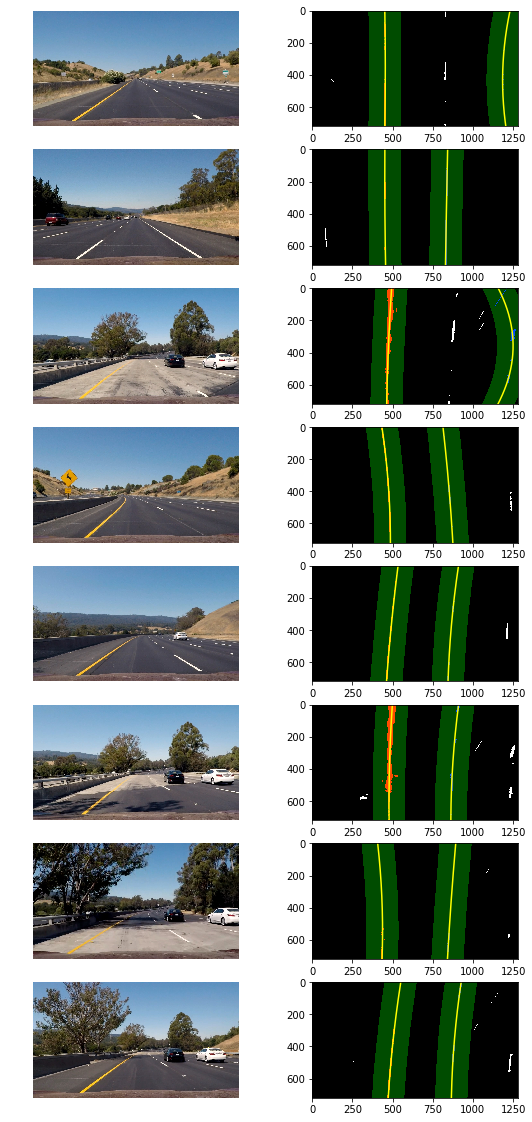

In [155]:
lane_lines_test_plt()

As shown above, all lane lines are correctly detected and drawn excetp for the 1st and 3rd images, as ther histogram shows peaks on the right side of the road instead of the lane line!!! so, I tried in the begining of my algorithm use the histogram of the bottom 1/3 part of the image instead of the bottom 1/2, and it helped in detecting the lane-lines correctly for all images. As shown below: 

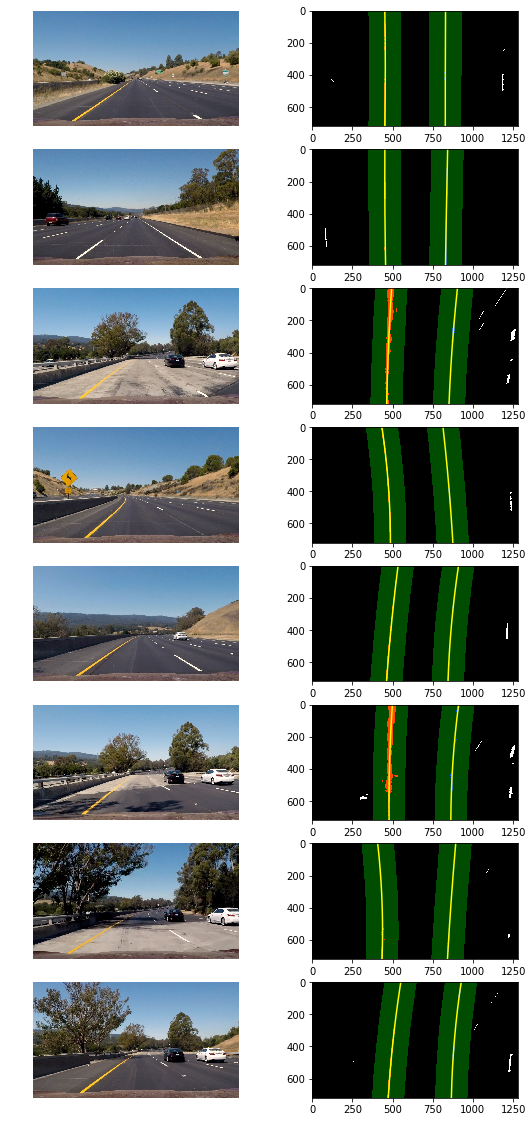

In [162]:
lane_lines_test_plt()

# Step 6: Measuring lane curvature  and Vehicle position w.r.t center

In [20]:
def lane_curvature_vehicle_position(bin_img, ploty, leftx, rightx):
    '''
    this function is used to measure the curvature radius for left and right lanes, and car position w.r.t. center
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Geting the difference between center of the image and the center of the lane
    image_center = bin_img.shape[0]/2 # center of the image in pixels
    image_center = image_center * xm_per_pix
    lane_center =  np.mean([left_fit_cr, right_fit_cr])
    car_position = abs(image_center - lane_center)
    return left_curverad, right_curverad, car_position
    
print('end')    
    

end


left curvature radius=  1576.19975871 m 
right curvature radius=  4265.89670869 m 
car position w.r.t.center=  0.798783884219 m


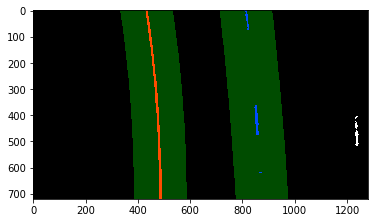

In [228]:
# test drawing lane lines fit  on test2.jpg
img = mpimg.imread('test_images/test2.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  

left_fit, right_fit = lane_lines(bin_img)
left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = lane_lines_fit(bin_img, left_fit, right_fit)
result, left_fitx, right_fitx, ploty = visualize_lane_lines_fit(bin_img,left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
left_curverad, right_curverad, car_position = lane_curvature_vehicle_position(bin_img, ploty, left_fitx, right_fitx)

plt.imshow(result)
print('left curvature radius= ',left_curverad, 'm','\nright curvature radius= ', right_curverad, 'm','\ncar position w.r.t.center= ',car_position,'m')

For the position of the vehicle w.r.t center point, I  assumed that the camera is perfectly located at the middle of the car, and the deviation of the mid-point of the lane from the center of the image is considered the position of the vehicle w.r.t. center point.

# Step 7: Warp detected lanes back to original image.

In [21]:
def unwarp(img,Minv):
    '''
    use this function to unwarp warped images
    '''
    img_size = (img.shape[1], img.shape[0])
    unwarp_img = cv2.warpPerspective(img, Minv, img_size )
    return unwarp_img

Text(0.5,1,'un-warped image')

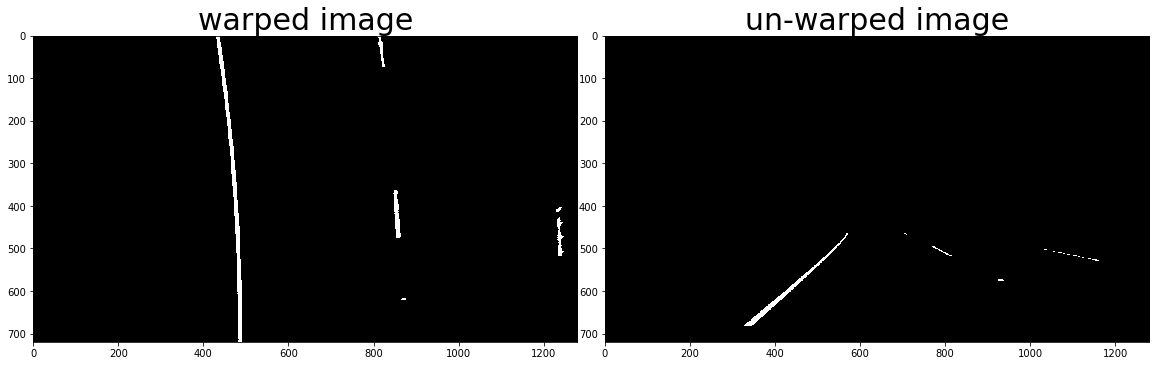

In [199]:
# test unwarp( )  funciton on test2.jpg

img = mpimg.imread('test_images/test2.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
unwarped_img =unwarp(bin_img, Minv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(bin_img, cmap= 'gray')
ax1.set_title('warped image', fontsize=30)
ax2.imshow(unwarped_img, cmap='gray')
ax2.set_title('un-warped image', fontsize=30)

In [22]:
def draw_lines(normal_img, binary_img,ploty, left_fitx, right_fitx,  Minv):
    #create another copy of original image to draw lines on it
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    colored_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    img_size = (colored_warp.shape[1], colored_warp.shape[0])
    
     # Recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lines_pts = np.hstack((left_line, right_line))
    
    # Draw the lines on the warped binary image
    cv2.fillPoly(colored_warp, np.int_([lines_pts]), (0,255, 0))
    cv2.polylines(colored_warp, np.int32([left_line]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(colored_warp, np.int32([right_line]), isClosed=False, color=(0,255,255), thickness=15)
    
    # uwarp the warped image image back before combineing with the original image
    unwarped_img =unwarp(colored_warp, Minv)
   
    # Combine the result with the original image
    result = cv2.addWeighted(normal_img, 1, unwarped_img, 0.3, 0)
    
    
    return result

print('end')

end


left curvature radius=  1576.19975871 m 
right curvature radius=  4265.89670869 m 
car position w.r.t.center=  0.798783884219 m


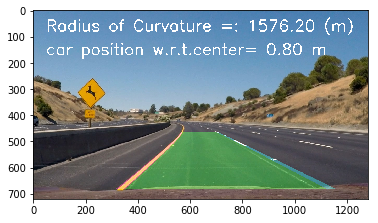

In [233]:
# test draw_lines( )  funciton on test2.jpg

img = mpimg.imread('test_images/test2.jpg')
bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  

left_fit, right_fit = lane_lines(bin_img)
left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = lane_lines_fit(bin_img, left_fit, right_fit)
result, left_fitx, right_fitx, ploty = visualize_lane_lines_fit(bin_img,left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
left_curverad, right_curverad, car_position = lane_curvature_vehicle_position(bin_img, ploty, left_fitx, right_fitx)
result = draw_lines(img, bin_img,ploty, left_fitx, right_fitx,  Minv)

curverad = (left_curverad + right_curverad)/2   

cv2.putText(result, 'Radius of Curvature =: {:.2f} (m)'.format(left_curverad), (50,80), cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=( 255,255,255),  thickness = 4)
#cv2.putText(result, 'right curvature radius=: {:.2f} m'.format(right_curverad), (50,130),  cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=(255,255,255), thickness = 4)
cv2.putText(result, 'car position w.r.t.center= {:.2f} m'.format(car_position), (50,170),  cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=(255,255,255), thickness = 4)
plt.imshow(result)

print('left curvature radius= ',left_curverad, 'm','\nright curvature radius= ', right_curverad, 'm','\ncar position w.r.t.center= ',car_position,'m')
    
    


## Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

This step is done in the above piece of code.

## Step 9:  Writing a complete pipeline

In [23]:
def final_pipeline(img):
    '''
    this function merges all previous steps together
    '''
    bin_img, Minv = pipeline(img, ksize=7, thresh1=(20, 100), mag_thresh1=(30, 100), dir_thresh1=(0.7, 1.3), s_thresh1=(170, 255))  
    left_fit, right_fit = lane_lines(bin_img)
    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = lane_lines_fit(bin_img, left_fit, right_fit)
    result, left_fitx, right_fitx, ploty = visualize_lane_lines_fit(bin_img,left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
    left_curverad, right_curverad, car_position = lane_curvature_vehicle_position(bin_img, ploty, left_fitx, right_fitx)
    result = draw_lines(img, bin_img,ploty, left_fitx, right_fitx,  Minv)

    curverad = (left_curverad + right_curverad)/2   

    cv2.putText(result, 'Radius of Curvature =: {:.2f} (m)'.format(left_curverad), (50,80), cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=( 255,255,255),  thickness = 4)
    cv2.putText(result, 'car position w.r.t.center= {:.2f} m'.format(car_position), (50,170),  cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=(255,255,255), thickness = 4)
    return result
print('end')

end


## Step 10: Testing on Videos  

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [235]:
output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:50<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 6min 2s
